In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [6]:
path = "EoS_posterior_samples_PSR+GW+NICER.h5"
mat = []

with h5py.File(path, "r") as h5:
    group_key = list(h5.keys())[2]
    eos_keys = list(h5[group_key].keys())

    for item in eos_keys:
        ds = h5[group_key][item]                 # dataset (e.g., "eos_0")
        rhoc   = ds["rhoc"]
        M      = ds["M"]
        R      = ds["R"]
        Lambda = ds["Lambda"]
        fmode   = ds["f"]
        temp = np.array([rhoc, M, R, Lambda, fmode], dtype=object)
        mat.append(temp)



In [7]:
mat_arr = np.array(mat, dtype=object) # rhoc, M, R, Lambda, f
print(mat_arr.shape) # eos, mrflambdafmode, len of data

(9835, 5, 40)


In [8]:
rhoc_mat = mat_arr[:, 0, :]
M_mat = mat_arr[:, 1, :]
R_mat = mat_arr[:, 2, :]
Lambda_mat = mat_arr[:, 3, :]
fmode_mat = mat_arr[:, 4, :]

In [9]:
# regularize grid
from scipy.interpolate import interp1d
m_grid = np.linspace(np.min(M_mat), np.max(M_mat), 100)

def _interpolate(mat, M_mat, m_grid):
    interp = []
    for i in range(mat.shape[0]):
        f_interp = interp1d(M_mat[i], mat[i], bounds_error=False, fill_value=np.nan)
        interp.append(f_interp(m_grid))
    interp = np.array(interp)
    return interp


fmode_interp = _interpolate(fmode_mat, M_mat, m_grid)
rhoc_interp = _interpolate(rhoc_mat, M_mat, m_grid)
R_interp = _interpolate(R_mat, M_mat, m_grid)
Lambda_interp = _interpolate(Lambda_mat, M_mat, m_grid)
m_interp = m_grid

In [10]:
def get_envelope(mat, lower_p = 2.5, upper_p = 97.5):
    upper = []
    lower = []
    median = []
    for i in range(mat.shape[1]):
        upper.append(np.nanpercentile(mat[:, i], upper_p))
        lower.append(np.nanpercentile(mat[:, i], lower_p))
        median.append(np.nanpercentile(mat[:, i], 50.0))
    return np.array(upper), np.array(lower), np.array(median)

(1.0, 3.0)

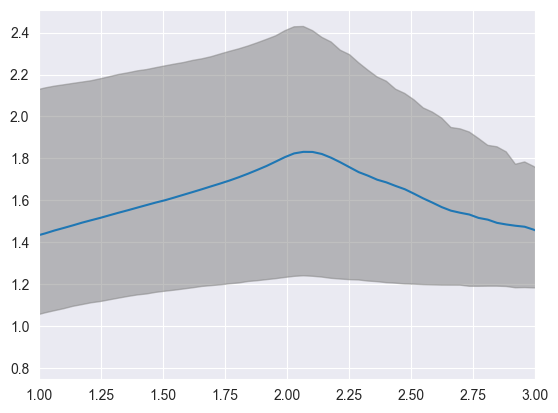

In [11]:
lower_f, upper_f, median_f = get_envelope(fmode_interp)
plt.plot(m_grid, median_f)
plt.fill_between(m_grid, lower_f, upper_f, color='gray', alpha=0.5)
plt.xlim(1, 3)

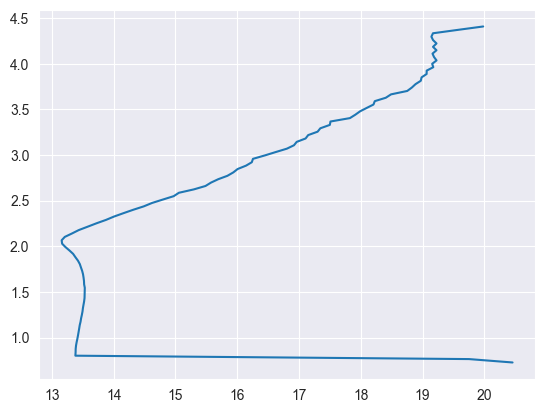

In [12]:
lower_r, upper_r, median_r = get_envelope(R_interp)
plt.plot(median_r, m_grid)

Text(0, 0.5, 'Lambda')

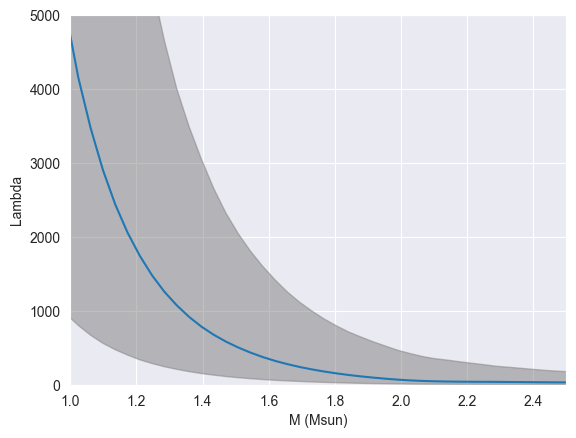

In [13]:
lower_lambda, upper_lambda, median_lambda = get_envelope(Lambda_interp)
plt.plot(m_grid, median_lambda)
plt.fill_between(m_grid, lower_lambda, upper_lambda, color='gray', alpha=0.5)
plt.ylim(0, 5000)
plt.xlim(1, 2.5)
plt.xlabel('M (Msun)')
plt.ylabel('Lambda')

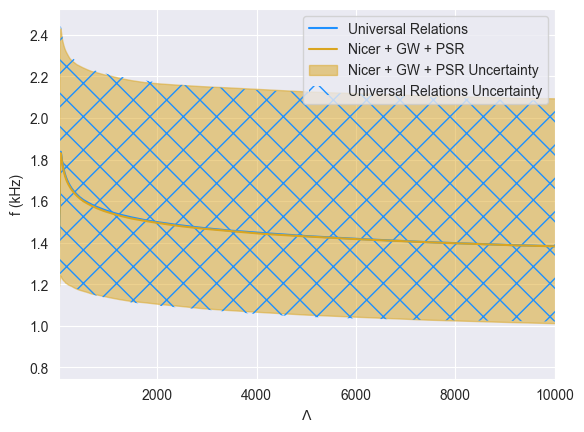

In [14]:
def universal_relations(lamba2, m_grid):
    G = 6.67259e-8
    c = (2.99792458e10) # cm/s
    M = m_grid
    x = np.log(lamba2)
    a0 = 1.82e-1
    a1 = -6.665e-3
    a2 = -4.212e-3
    a3 = 4.724e-4
    a4 = -1.030e-6
    a5 = -2.139e-6
    a6 = 8.763e-8
    w2m = a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4 + a5*x**5 + a6*x**6
    w2 = w2m/M
    f2 = 32.35 * w2 # See attached pdf to see where this number comes from. "conversion_derivation.pdf"
    return f2

universal_f = universal_relations(median_lambda, m_grid)
universal_f_lower = universal_relations(lower_lambda, m_grid)
universal_f_upper = universal_relations(upper_lambda, m_grid)

# def universal_relations(r, m_grid):
#     c2 = (2.99792458e10)**2 # cm/s
#     M = m_grid*2.0e33
#     R = r*1e5  # convert to cm
#     I = M*(R**2)
#     eta = np.sqrt((M**3)/(I*c2))
#     f2m = -0.0047 + 0.133*eta + 0.575*(eta**2)
#     f2 = f2m/M
#     return f2
# universal_f = universal_relations(median_r, m_grid)
# universal_f_lower = universal_relations(lower_r, m_grid)
# universal_f_upper = universal_relations(upper_r, m_grid)

plt.figure()
plt.plot(median_lambda, universal_f, label = "Universal Relations", color = 'dodgerblue')
plt.plot(median_lambda, median_f, label = "Nicer + GW + PSR", color = "goldenrod")
plt.fill_between(median_lambda, lower_f, upper_f, color='goldenrod', alpha=0.5, label = "Nicer + GW + PSR Uncertainty")
plt.fill_between(
    median_lambda,
    universal_f_lower,
    universal_f_upper,
    facecolor="none",        # no solid fill
    hatch="x",               # hatch pattern
    edgecolor="dodgerblue",  # color of hatch lines
    linewidth=0.0,            # keep edges thin
    label = "Universal Relations Uncertainty")
plt.xlabel(r'$\Lambda$')
plt.ylabel('f (kHz)')
plt.xlim(1e1, 1e4)
# plt.ylim(0, 10)
# plt.xscale('log')
plt.legend(loc = "upper right")
plt.savefig('fmode_lambda_universal_vs_NICER_GW_PSR.png', dpi=300)

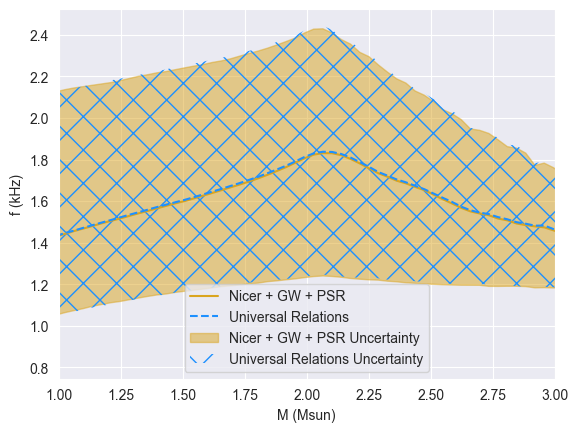

In [15]:
# universal_f depends on lambda2(m)
plt.figure()
plt.plot(m_grid, median_f, color = "goldenrod", label = "Nicer + GW + PSR")
plt.plot(m_grid, universal_f, label = "Universal Relations", color = 'dodgerblue', linestyle = '--')
plt.fill_between(m_grid, lower_f, upper_f, color='goldenrod', alpha=0.5, label = "Nicer + GW + PSR Uncertainty")
plt.fill_between(
    m_grid,
    universal_f_lower,
    universal_f_upper,
    facecolor="none",        # no solid fill
    hatch="x",               # hatch pattern
    edgecolor="dodgerblue",  # color of hatch lines
    linewidth=0.0,            # keep edges thin
    label = "Universal Relations Uncertainty")
plt.xlim(1, 3)
plt.legend()
plt.xlabel('M (Msun)')
plt.ylabel('f (kHz)')
plt.savefig('fmode_mass_universal_vs_NICER_GW_PSR.png', dpi=300)